# Unsupervised annotation in DeepOF - exploring the behavioral space

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucasmiranda42/deepof/blob/master/docs/source/tutorial_notebooks/deepof_unsupervised_tutorial.ipynb)

##### what we'll cover:
    
* Brief introduction to unsupervised analysis.
* Load your previous project.
* Understanding the different available models.
* Running an unsupervised analysis with default parameters.
* Temporal and global embeddings.
* Global separation dynamics.
* Exploring cluster enrichment across conditions.
* Exploring cluster dynamics across conditions.
* Interpreting clusters using SHAP.
* Exporting cluster video snippets.

In [1]:
# # If using Google colab, uncomment and run this cell and the one below to set up the environment
# import os, warnings
# warnings.filterwarnings('ignore')
# !pip install -q --ignore-installed deepof --progress-bar off
# !curl --output tutorial_files.zip https://datashare.mpcdf.mpg.de/s/Hu1XjZkY9zml0mm/download
# !unzip tutorial_files.zip

Let's start by importing some packages. We'll use python's os library to handle paths, pickle to load saved objects, and the data entry API within DeepOF, located in deepof.data. This time we'll add copy and numpy to the mix.

**NOTE**: If running this notebook in colab, we strongly recommend using a GPU environment. Go to 'Runtime' -> 'Change runtime type', and select GPU under 'Hardware accelerator'.

In [2]:
import copy
import os
import numpy as np
import pickle
import deepof.data

We'll also need some plotting gear:

In [3]:
from IPython import display
from networkx import Graph, draw
import deepof.visuals
import matplotlib.pyplot as plt
import seaborn as sns

### Brief introduction to unsupervised analysis

So far we saw how to create a project, and to apply pre-defined supervised annotators to our tracked animals. We also saw how we can use those to compare across two experimental conditions. In this tutorial, we'll cover how to get the most of DeepOF by embedding our time series directly using a deep learning model that can obtain and compare different clusters of behavior across our cohorts.

In a nutshell, unsupervised learning is a powerful technique for analyzing time series data, (in this case behavioral motion tracking in mice). With this type of analysis, you can identify patterns and structures in your data without needing labeled examples or a pre-existing hypothesis. This makes it a great tool for exploratory data analysis, allowing you to uncover hidden relationships and insights that might not be immediately apparent. This way you can gain a deeper understanding of the underlying patterns and behaviors of your mice, which can ultimately help you make more informed decisions in your research.

### Load your previous project

In [4]:
# We load only a small sample project to speed up the following steps
my_deepof_project = deepof.data.load_project("./tutorial_files/sample_project")

### Processing time series for unsupervised learning

The unsupervised pipeline starts by creating training and validation datasets that we'll later on pass to the deep learning models. DeepOF provides a couple of functions to do this on its own, as we'll see shortly. Importantly, and where the details of the pipeline are beyond the scope of this tutorial (check the main paper if you're interested), there are two concepts that we should cover to make interacting with the workflow as easy as possible.

First, we'll see that, when generating a dataset, DeepOF applies a sliding window across all features in the data. Sliding windows are a commonly used technique in time series analysis that involves dividing the data into smaller, fixed-size windows and applying analysis techniques on each window. This approach is useful for unsupervised learning because it allows for the exploration of patterns and trends in the data over time.

The size of the window refers to the number of data points in each segment, and the stride is the number of data points by which the window moves forward in each step. By adjusting the window size and stride, different patterns and trends can be extracted from the time series. For example, a smaller window size with a larger stride can capture short-term changes in the data, while a larger window size with a smaller stride can reveal longer-term trends. We'll see that DeepOF allows us to control these parameters, although default values should work well in most cases.

On the other hand, DeepOF offers a more advanced input pipeline that's optimized for top-down videos. This includes representing the different created features as a graph, with nodes as body parts and edges connecting those that are adjacent in space. Thus, DeepOF can automatically annotate the animals across time with coordinates, speeds, and distances. This is particularly useful when access to crucial body parts (such as paws) are occluded (such as in top-down videos). Moreover, this input pipeline enables the joint embedding of multiple animals: when more than one mouse is present, all nose-nose, nose-tail, and tail-tail distances are included in the graph, and annotated with their respective distances.

![unsupervised_processing](./Assets/deepof_unsupervised_processing.png)

Let's see how we can generate datasets with and without graphs:

Let's start simple: we can omit the graph representations and generate DeepOF-ready datasets by running the `.preprocess()` method on any TabDict object (TabDict are the dictionary-like structures that we saw in the first tutorial).

In [5]:
# This code will generate a dataset without graph representations
coords = my_deepof_project.get_coords(selected_id="B", center="Center", align="Spine_1")
preprocessed_coords, shapes, global_scaler = coords.preprocess(
    coordinates=my_deepof_project,
    window_size=25, # Sliding window length
    window_step=1, # Sliding window stride
    test_videos=1, # Number of videos in the validation set
    scale="standard", # Scaling method
    save_as_paths=True,
)

Get testing windows           : 100%|██████████| 1/1 [00:00<00:00,  2.99table/s]


The first thing to notice here is that we're only passing the coordinates as input (no speed, no distances). While a merged object can be passed in theory to get embeddings that carry other signals (see tutorial on preprocessing), that often leads in practice to unstable training (at least in our experiments). So let's continue with coordinates only!

Next, you may have already seen that the `.preprocess()` method returns two objects, the preprocessed coordinates, and a global scaler. Let's explore these in more detail.

Upon exploring, we see that preprocessed_coords is a tuple containing four numpy arrays. These correspond to training and validation features (X) and label (y) datasets, respectively. Labels in the unsupervised pipeline are beyond the scope of this tutorial, which only deals with purely unsupervised models. 

Focusing on the features, then, let's explore their shapes:

In [6]:
print("Features in the training set have shape {}".format(shapes[0]))
print("Features in the validation set have shape {}".format(shapes[1]))

Features in the training set have shape (74873, 25, 22)
Features in the validation set have shape (14975, 25, 22)


The first axis in these shapes corresponds to the number of sliding windows per dataset (we have 6 videos in total in this tutorial, and one has been assigned to the validation set. Note that's important to split videos (and not sliding window instances) to have truly independent training and validation data.

The other two axes relate to sliding window size (same as the frame rate of the provided videos, by default, so each sliding window includes a second of data), and the number of features (11 body parts, _x_ and _y_ coordinates).

To understand the global_scaler object, let's first briefly review how DeepOF normalizes data. First, data coming from each video are normalized independently in both training and validation sets, which helps correct for differences in body size. All videos in the training set are then scaled together, and the fitted global_scaler is then returned for further processing as we'll see below.

Next, let's generate a graph-based dataset and understand its output. To do this, we can preprocess our coordinates directly (no need to create the feature objects by ourselves) using the `.get_graph_dataset()` method. Under the hood, DeepOF will create a TableDict object containing centered and aligned coordinates, speeds, and distances corresponding to the edges of the aforementioned graph. Let's see it in action:

**NOTE**: the embeddings we use throughout this tutorial are single-animal by default. This is controlled by the 'animal_id' parameter in the method call below. If you'd like to try how multi-animal data is processed, comment the parameter out. Processing is quite similar, but the graph is larger as it will include both animals, as well as the distances between them.

In [7]:
# This code will generate a dataset using graph representations, as well a some auxiliary objects
graph_preprocessed_coords, shapes, adj_matrix, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B", # Comment out for multi-animal embeddings
    center="Center",
    align="Spine_1",
    window_size=25,
    window_step=1,
    test_videos=1,
    preprocess=True,
    scale="standard",
)

Reshaping                     : 100%|██████████| 2/2 [00:00<00:00,  8.03table/s]


We see that now the pipeline returned four objects instead of two. The first one is equivalent to the preprocessed_coords, although the tuple now contains 6 elements, and their shapes in the arrays are different. Instead of just features and labels for the training and validation sets, we now have:

* Node features for the training set, with shape window instances × window size × features (which include coordinates and speeds per body part)
* Edge features for the training set, with shape window instances × window size × features (which include distances between adjacent body parts)
* Labels in the training set
* Node features for the validation set, with shape window instances × window size × features (which include coordinates and speeds per body part)
* Edge features for the validation set, with shape window instances × window size × features (which include distances between adjacent body parts)
* Labels in the validation set

In [8]:
print("Node features in the training set have shape {}".format(shapes[0]))
print("Edge features in the training set have shape {}".format(shapes[1]))
print("Node features in the validation set have shape {}".format(shapes[2]))
print("Edge features in the validation set have shape {}".format(shapes[3]))

Node features in the training set have shape (74874, 25, 33)
Edge features in the training set have shape (74874, 25, 11)
Node features in the validation set have shape (14974, 25, 33)
Edge features in the validation set have shape (14974, 25, 11)


The second returned object is the adjacency matrix of the aforementioned connected graph as a numpy array (where rows and columns correspond to each body part, and ones indicate connections). Let's have a look!

In [9]:
print(adj_matrix)

[[0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0 0 0 0 0]
 [1 0 0 1 0 0 0 1 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 1 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]]


We can also plot it:

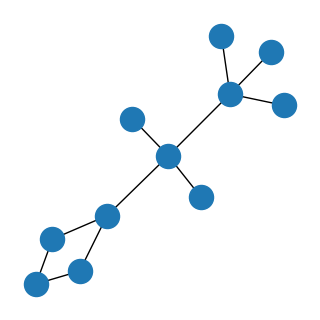

In [10]:
plt.figure(figsize=(3, 3))
draw(Graph(adj_matrix))
plt.show()

Finally, the two last objects correspond to the TableDict object with the features (useful later on, as we'll see shortly) and the already explained global scaler.

So, with just a few commands, we already have everything we need to train our first deep clustering models. Let's briefly explore how they work and get on with the training!

### Embedding our data with deep clustering models

The core idea of deep clustering is to embed our input (the motion features over time) with a neural network, and retrieve a set of embeddings per time point (a reduced representation in the form of a vector) each of which is assigned to a cluster. In this context, clusters correspond to systematic behaviors the model observes in the provided cohort.

DeepOF has three main models it can offer. Two of them (called [VaDE](https://arxiv.org/abs/1611.05148) and [VQVAE](https://arxiv.org/abs/1711.00937) after the models from the literature they are based on) are [**autoencoders**](https://blog.keras.io/building-autoencoders-in-keras.html). This means that the architecture consists of two parts, an encoder and a decoder, which are trained jointly in a way in which the output is optimized to reconstruct the input. Moreover, a clustering structure is imposed in the latent space that forms in between, so that embeddings are thought of as coming from one of a set of jointly trained components. While VaDE (left on the figure below) treats each component as a multivariate Gaussian distribution in a continuous space, VQVAE models (right on the figure below) use a codebook mapping to a discrete representation space. More details on both VaDE and VQVAE can be found [here](https://medium.com/machine-intelligence-and-deep-learning-lab/variational-deep-embedding-403fb476ed7f) and [here](https://ml.berkeley.edu/blog/posts/vq-vae/), respectively.

For now, let's just say that VaDE models are a lot more stable (at least in our experiments) when working with graph input, so we've assigned them as default. You can still try the VQVAE models with your data if you'd like, though!

![unsupervised_models](./Assets/deepof_unsupervised_models.png)

The third class of models use a different architecture altogether, which is based in [contrastive learning](https://lilianweng.github.io/posts/2021-05-31-contrastive/). This produces embeddings without the need for a decoder, but clustering must be conducted post-hoc, which DeepOF takes care of using a Hidden Markov Model.

With all of this in mind, let's see how this works in practice. To train a model, you need to call the `.deep_unsupervised_embedding()` method on your coordinates. Some parameters we should take into account when doing so are:

* preprocessed_object, which corresponds to the dataset tuples generated above (either preprocessed_coords or graph_preprocessed_coords, for matrix and graph input respectively).
* adjacency_matrix, required for graph input.
* embedding_model, corresponding to the model to use. Can be set to 'VaDE' (default), 'VQVAE', or 'Contrastive'
* encoder_type, corresponding to the architecture that the models use for the encoder (and decoder if available). Can be set to 'recurrent' (default), TCN, or transformer.
* n_components, corresponding to the number of clusters to train.
* latent_dim, corresponding to the size of the produced embeddings.
* interaction_regularization, which is only applicable when multi-animal embeddings are at play. Higher values will force the model to focus more on interactions rather than on joint individual behaviors. For reference, in the multi-animal embeddings depicted in the main DeepOF paper the parameter was set to 0.5.
* pretrained, which loads already saved weights within your DeepOF model instead of training a new model. By default, DeepOF will attempt to load the latest trained weights with the specified parameters. See the **NOTE** below to see how to select between different sets of weights in case you need to.

For more details, feel free to open the full API reference.

**NOTE**: Trained weights are saved under __Trained_models/trained_weights__ in your project directory. If you'd like to manually select the weights to load, browse to the corresponding folder and input the name of the file of choice, instead of a boolean.

**NOTE2**: If you set pretrained to False in the cell below, it can take a while to run in some cases (around 20 min in a GPU environment in Colab).

In [11]:
trained_model = my_deepof_project.deep_unsupervised_embedding(
    preprocessed_object=graph_preprocessed_coords, # Change to preprocessed_coords to use non-graph embeddings
    adjacency_matrix=adj_matrix,
    embedding_model="VaDE", # Can also be set to 'VQVAE' and 'Contrastive'
    epochs=10,
    encoder_type="recurrent", # Can also be set to 'TCN' and 'transformer'
    n_components=10,
    latent_dim=6,
    batch_size=1024,
    verbose=True, # Set to True to follow the training loop
    interaction_regularization=0.0,
    pretrained=True, # Set to False to train a new model!
)

While we won't explore the models themselves in detail in this tutorial, some hints you may want to try on your own are:

* `trained_model.summary()` will print a detailed description of the trained model and its parameters
* `trained_model.encoder()` will encode data to the latent space
* `trained_model.grouper()` will retrieve the clustering output

Once we have a trained model, it's time to finally get our embeddings! This can be done using the `deepof.model_utils.embedding_per_video()` function. This will return TableDict objects containing the embeddings, soft_counts, and breaks per experiment. These are:

* embeddings: a TableDict object containing embdings per time point per experiment.
* soft_counts: soft cluster assignments per video. The values per time point can be interpreted as the probability the model assigns to each cluster. The cluster with maximum probability will be assigned in the end. This soft clustering approach allows us to filter time points with low confidence, as we'll see.
* breaks: length of each time point. By default, it corresponds to the stride assigned to the sliding window. This object is here for legacy reasons, as it enables compatibility with a change point detection pipeline that won't be explored in this tutorial.

In [12]:
# Get embeddings, soft_counts, and breaks per video
embeddings, soft_counts = deepof.model_utils.embedding_per_video(
    coordinates=my_deepof_project,
    to_preprocess=to_preprocess, 
    model=trained_model,
    animal_id="B",
    global_scaler=global_scaler,
)

Computing embeddings          : 100%|██████████| 6/6 [01:44<00:00, 17.47s/table]


As the training set in this tutorial is quite small, we'll load embeddings from a model trained on the full dataset of 53 videos for the rest of the presented analyses. Feel free to try the remaining cells with your trained model by skipping the cell below, though!

In [13]:
# Load results
my_deepof_project = deepof.data.load_project("./tutorial_files/tutorial_project")
with open(
    "./tutorial_files/tutorial_project/Trained_models/trained_weights/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=6_k=10_20240717-214855_final_weights.pkl", "rb"
) as handle:
    embeddings, soft_counts, breaks = pickle.load(handle)


So we finally have our trained embeddings, and our data has been clustered. Let's see what sort of tools DeepOF offers to analyze the results, then!

### Visualizing temporal and global embeddings

The first thing we can do is to visualize the cluster space. If you went through the tutorial on supervised analysis, you're already familiar with the `deepof.visuals.plot_embeddings()` function. Here we'll run it again, with slightly different parameters (passing embeddings, soft_counts, and breaks instead of the supervised annotations). As in the previous tutorial, all figures shown in the documentation version of this tutorial were produced using the full 53 animal dataset.

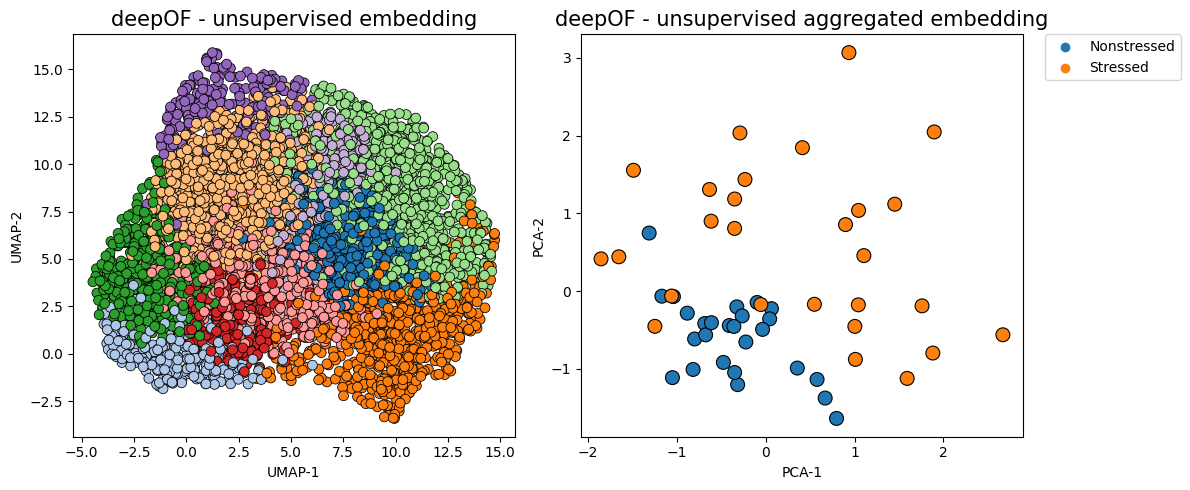

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

The figure on the left now shows time points in a UMAP projection of the latent space, where colors indicate different clusters. The figure on the right aggregates all time points in a given animal as a vector of counts per behavior (indicating how much time each animal spends on each cluster). We can already see a clear separation between conditions, in a fully unsupervised way!

### Generating Gantt charts with all clusters

Like we did for the supervised annotations, we can also visualize assigned clusters over time using Gantt charts:

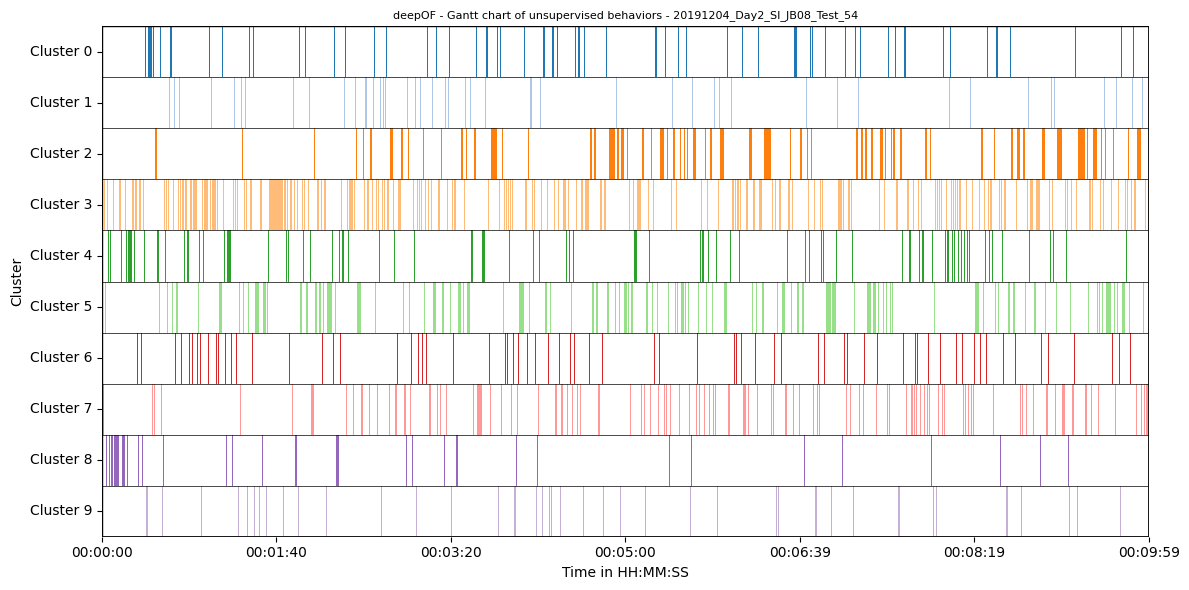

In [15]:
fig = plt.figure(figsize=(12, 6))

deepof.visuals.plot_gantt(
    my_deepof_project,
    soft_counts=soft_counts,
    instance_id="20191204_Day2_SI_JB08_Test_54",
)

### Global separation dynamics

Next, let's quantify the distance between our experimental distributions. To measure how far the behavior of stressed animals is from that of controls, we'll use the [Wasserstein distance](http://alexhwilliams.info/itsneuronalblog/2020/10/09/optimal-transport/) between the distributions shown on the right panel of the figure above. Moreover, we'll see how that distance evolves over time. To this end, we can use the `deepof.visuals.plot_distance_between_conditions()` function. 

Found an optimal_bin at 50 seconds


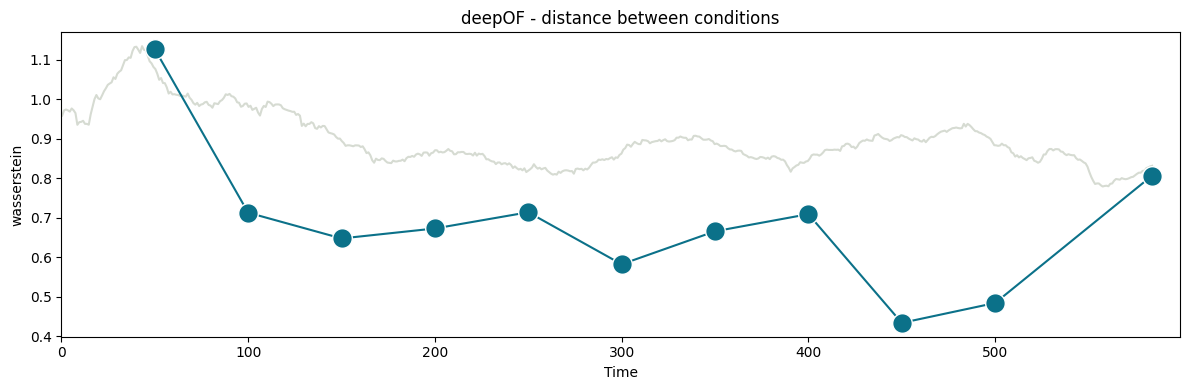

CPU times: total: 2min 31s
Wall time: 2min 27s


In [16]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    
deepof.visuals.plot_distance_between_conditions(
    my_deepof_project,
    embeddings,
    soft_counts,
    "CSDS",
    distance_metric="wasserstein",
    n_jobs=1,
)

plt.show()

In the figure above, you can see two curves. The grey one in the background measures how the distance between conditions evolves over a growing window over time. We start with 10 seconds of data, and add one at the time until all 600 are included (the underlying videos are 10-minutes long). Peaks in this curve can then point towards points in the time series that maximize the difference between conditions. Here, we see a maximum at 50 seconds.

The function then selects 50 seconds as the optimal binning break, and splits the experiments in equally-sized bins (except for the last one, which is a bit smaller). The distance across consecutive bins is then reported in the green curve, which we see decay over time as the distributions become closer and closer. We can map these back to the embeddings we displayed before, and filter them over time:

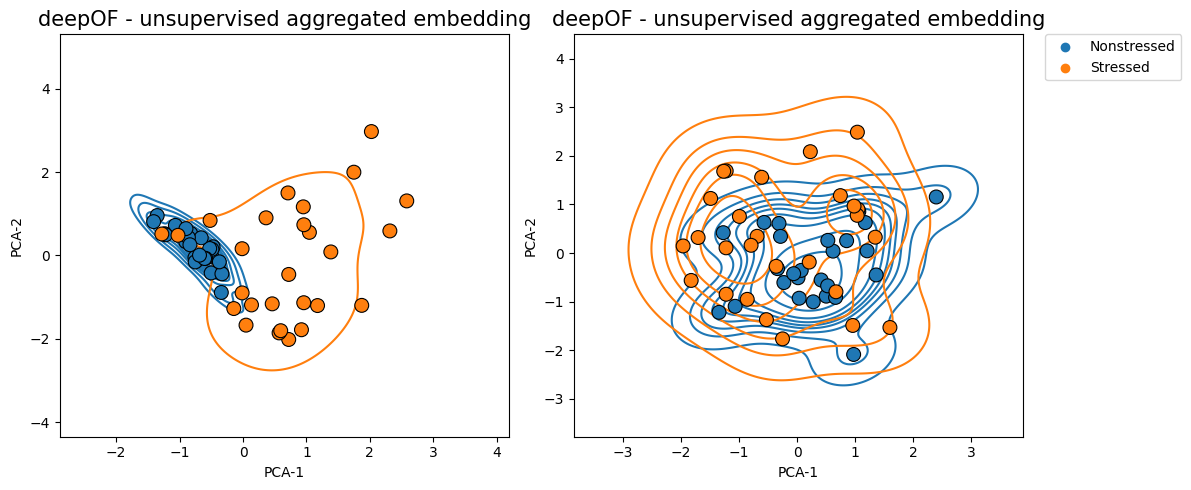

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


deepof.visuals.plot_embeddings(
    my_deepof_project, 
    embeddings, 
    soft_counts,
    aggregate_experiments="time on cluster",
    bin_size=50, # This parameter controls the size of the time bins. We set it to match the optimum reported above
    bin_index=0, # This parameter controls the index of the bins to select, we take the first one here
    ax=ax1,
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings, 
    soft_counts,
    aggregate_experiments="time on cluster",
    exp_condition="CSDS",
    show_aggregated_density=True,
    bin_size=50, # This parameter controls the size of the time bins. We set it to match the optimum reported above
    bin_index=3, # This parameter controls the index of the bins to select, we take the fourth one here
    ax=ax2,
)
ax2.legend(
    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0
)

ax1.legend().remove()
plt.tight_layout()
plt.show()

Where we clearly see that the overlap between the distributions is greater in the figure on the right (and therefore their Wasserstein distance lower).

### Exploring cluster enrichment across conditions

Next, and as we did in the last tutorial on supervised annotation, we can test for enrichment in cluster expression! This way we can detect and pinpoint specific behavioral differences between our cohorts. Let's compare how the enrichment plots look for the whole data and the first time bin, respectively:

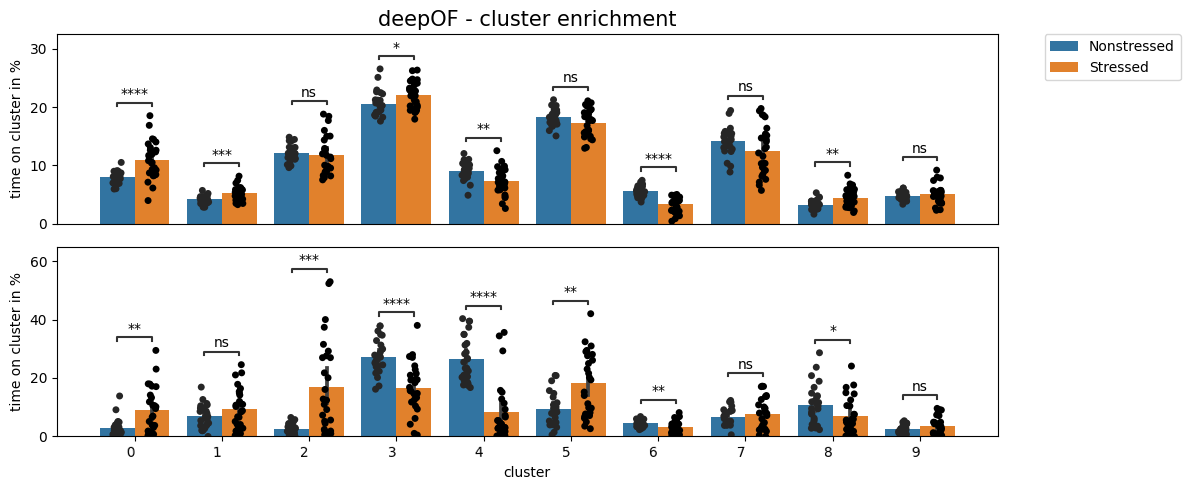

In [18]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 5))

deepof.visuals.plot_enrichment(
    my_deepof_project,
    embeddings,
    soft_counts,
    normalize=True,
    add_stats="Mann-Whitney",
    exp_condition="CSDS",
    verbose=False,
    ax=ax,
)

deepof.visuals.plot_enrichment(
    my_deepof_project,
    embeddings,
    soft_counts,
    normalize=True,
    bin_size=50,
    bin_index=0,
    add_stats="Mann-Whitney",
    exp_condition="CSDS",
    verbose=False,
    ax=ax2,
)
ax.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
ax.set_xlabel("")
ax2.legend().remove()
plt.title("")
plt.tight_layout()
plt.show()

We can see how, as expected, there are many more differences in the first time bin than in the entire time series. Moreover, we see a few clusters (3-5, for example) that are highly enriched in stressed animals in the first time bin, but less different or not different at all when looking at the whole time series. We'll visualize what these are at the end of this tutorial.

### Exploring cluster dynamics across conditions

Aside from exploring cluster enrichment, DeepOF provides tools to gain insight into cluster dynamics. That is, how transitions between different clusters look like. For example, we can have a look at the transition matrices per condition with `deepof.visuals.plot_transitions()`:

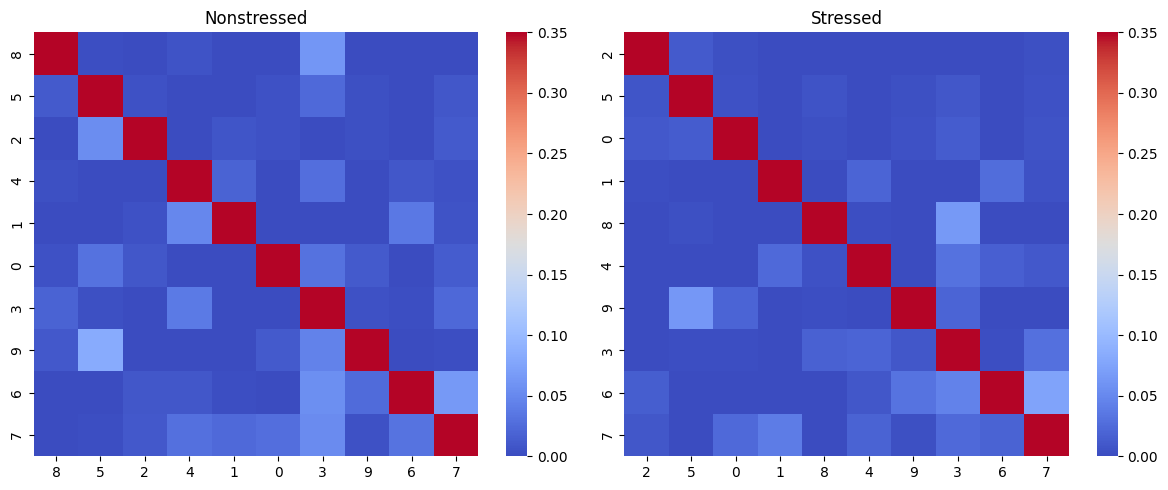

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Transition matrices and heatmaps
deepof.visuals.plot_transitions(
    my_deepof_project,
    None,
    soft_counts.filter_videos(my_deepof_project.get_exp_conditions.keys()),
    visualization="heatmaps",
    bin_size=50,
    bin_index=0,
    exp_condition="CSDS",
    ax=axes,
    delta_T=0.0,
    diagonal_behavior_counting="Transitions",
)

plt.tight_layout()
plt.show()

Here we can see heatmaps depicting how common transitions between components are. Rows and columns are clustered, to put clusters with common transitions between them together. As it may be hard to retrieve patterns from heatmaps visualized this way, the function can also represent them as graphs, where more common transitions are depicted with thicker edges:

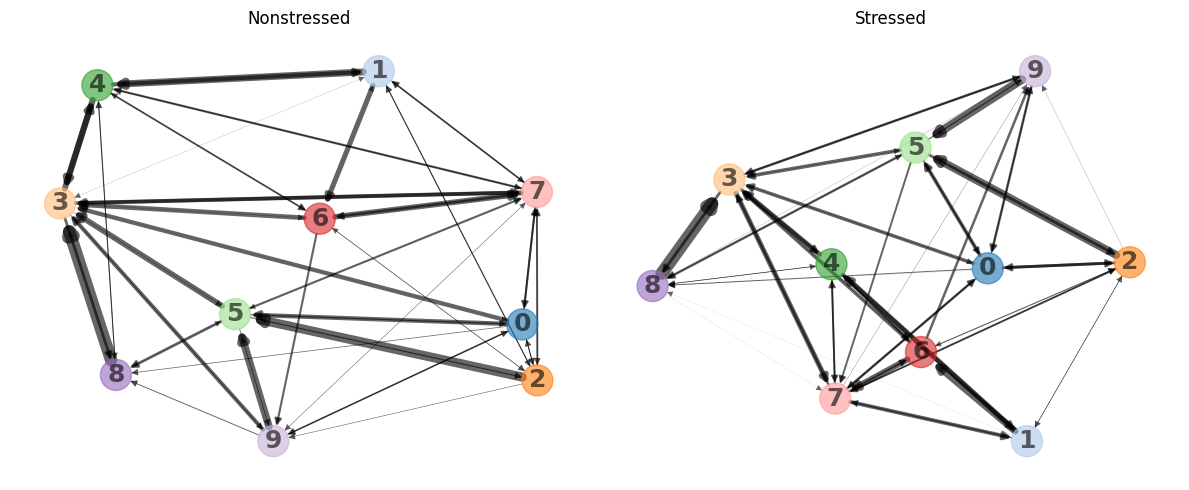

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings.filter_videos(my_deepof_project.get_exp_conditions.keys()),
    soft_counts.filter_videos(my_deepof_project.get_exp_conditions.keys()),
    visualization="networks",
    silence_diagonal=True,
    bin_size=50,
    bin_index=0,
    exp_condition="CSDS",
    ax=axes,
)

plt.tight_layout()
plt.show()

We can see how the state transitions for this model are relatively similar between nonstressed and stressed mice even though there are some noticable differences (e.g. the transition between 3 and 5 is slightly more frequent in the nonstressed group).

Moreover, we can explore how the overall behavioral entropy (which measures how predictable behavior for a given animal is) compares across experimental conditions. To obtain these values, DeepOF runs a set of simulations on the transition matrices depicted above, until the population of clusters converges to a stationary distribution. Entropy is then computed on this distribution for each animal, and the obtained values per condition are compared. The function that allows users to run this analysis is `deepof.visuals.plot_stationary_entropy()`, and it's executed as in the cell below:

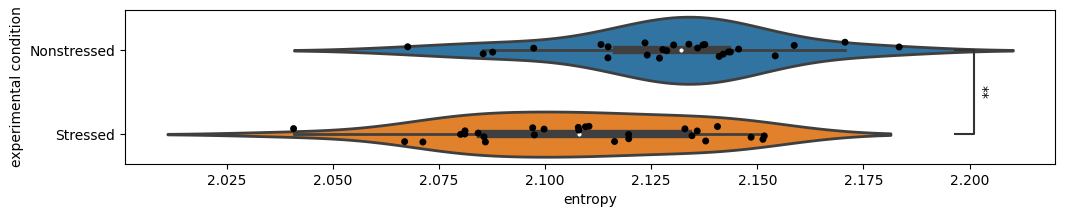

In [21]:
# Entropy plots
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

deepof.visuals.plot_stationary_entropy(
    my_deepof_project,
    embeddings,
    soft_counts,
    exp_condition="CSDS",
    ax=ax,
)

Here we see that behavioral entropy is follows an overal similar distribution but is on average significantly lower in stressed animals! This could be explained by the richer behavioral repertoire that non-stressed animals explore. Upon visualizing the attached videos, one can see that much of the time stressed animals are showing behaviors closer to freezing, while non-stressed animals tend to transition between different exploratory behaviors.

So far we've seen how to run the unsupervised pipeline to get both embeddings and cluster assignments, as well as how to compare the results across experimental conditions. In the last part of this tutorial, we'll explore one of the most important questions you may be asking: how do I know what the clusters mean?

### Interpreting clusters using SHAP

To interpret cluster assignments, DeepOF relies on two complementary approaches. The first one is to train a set of supervised classifiers that can predict cluster assignments given a set of features describing the sliding window input, such as distances, speeds, and areas of different body parts and regions, as well as the supervised annotators we generated in the last tutorial (if provided). For a more detailed description of the included features, refer to either the main DeepOF paper or the full API reference.

There are three steps in the cluster interpretation pipeline: feature extraction, classifier training, and SHAP value computation.

Let's start with feature extraction, which is computed using `deepof.post_hoc.annotate_time_chunks()`:

**NOTE**: the function below can require a significant amount of memory to run, especially in multi-animal settings. Try to use a work station, if possible.

In [22]:
# To include supervised annotations and allow DeepOF to report associations between supervised and unsupervised 
# annotations, we'll quickly run the supervised pipeline once again:
supervised_annotation = my_deepof_project.supervised_annotation() 

supervised annotations        : 100%|██████████| 53/53 [01:28<00:00,  1.67s/table, step=post processing]   


In [23]:
csds_chunk_stats, hard_counts, sampled_idcs_dict = deepof.post_hoc.annotate_time_chunks(
    deepof_project=my_deepof_project,
    soft_counts=soft_counts,
    supervised_annotations=supervised_annotation,
    animal_id="B",
    kin_derivative=1,
    window_size=25,
    include_distances=True,
    min_confidence=0.9,
    include_angles=False,
    include_areas=True,
    aggregate="mean",
    samples=10000,
)

Get training windows          : 100%|██████████| 53/53 [00:00<00:00, 367.38table/s]


The function returns three objects. The first one is a data frame with all extracted features over 10000 sampled sliding windows.

In [24]:
csds_chunk_stats

,"('B_Center', 'B_Spine_1')_raw","('B_Left_ear', 'B_Nose')_raw","('B_Center', 'B_Left_fhip')_raw","('B_Right_bhip', 'B_Spine_2')_raw","('B_Spine_2', 'B_Tail_base')_raw","('B_Center', 'B_Spine_2')_raw","('B_Left_ear', 'B_Spine_1')_raw","('B_Left_bhip', 'B_Spine_2')_raw","('B_Center', 'B_Right_fhip')_raw","('B_Nose', 'B_Right_ear')_raw",...,W_sniff-arena,W_immobility,W_stat-lookaround,W_stat-active,W_stat-passive,W_moving,W_sniffing,W_speed,B_missing,W_missing
0,11.792715,24.687872,14.644753,12.475008,12.306814,11.961204,14.301166,12.962065,13.481007,24.328532,...,0.0,0.92,0.00,0.00,1.00,0.00,0.00,14.971009,0.0,0.0
1,16.728530,18.338856,14.822211,14.693875,17.136868,16.622719,15.349126,13.644081,16.900647,17.038117,...,0.0,0.00,0.00,0.00,0.80,0.20,0.20,20.924627,0.0,0.0
2,15.171787,18.647080,14.134592,13.362113,14.773437,15.171126,17.074113,13.047997,15.106147,18.375199,...,1.0,0.00,0.00,0.32,0.68,0.00,0.20,13.949418,0.0,0.0
3,14.392730,18.867432,15.660319,12.200537,14.577505,14.701875,16.500203,13.915983,13.514573,20.788270,...,0.0,0.00,0.00,0.24,0.00,0.76,0.16,71.172520,0.0,0.0
4,16.693095,16.876995,15.746793,14.029735,17.141968,17.033489,18.553432,13.747227,15.144196,15.369878,...,0.0,0.00,0.00,0.84,0.00,0.16,0.16,77.370040,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,17.651234,18.811123,16.061253,14.634063,15.756157,17.020739,18.360353,15.280593,16.303997,17.821395,...,0.0,0.00,0.76,0.88,0.00,0.12,0.36,58.823461,0.0,0.0
9996,14.549775,16.094127,15.063883,12.033137,13.714367,14.118039,17.103674,12.450012,14.763825,20.037377,...,0.0,1.00,0.00,0.00,1.00,0.00,0.12,5.094961,0.0,0.0
9997,10.116085,16.673295,14.439942,12.753783,9.421393,9.992082,12.852725,14.227777,15.919731,19.083226,...,0.0,0.00,0.16,1.00,0.00,0.00,0.52,20.164931,0.0,0.0
9998,11.191088,22.117315,13.626116,13.368548,11.772971,12.397896,15.111646,13.656355,13.454634,23.295039,...,0.0,0.00,0.00,0.00,0.00,1.00,0.00,202.945789,0.0,0.0


The second one includes all corresponding cluster assignments as hard count integers (notice that we only took assignments that were made with a probability of 0.9 or higher, to select the most representative samples of each cluster).

In [25]:
hard_counts.values

array([5, 1, 6, ..., 5, 0, 5], dtype=int64)

Finally, the third one refers to the breaks per sample, as described before.

Let's now train a multi-output [gradient boosting machine](https://catboost.ai/en/docs/concepts/python-installation) to map between features and labels. DeepOF relies on the `deepof.post_hoc.train_supervised_cluster_detectors()` function, which by default runs a [stratified cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) loop to check how generalizable the obtained results are within the dataset. We'll run it with 10 folds:

In [26]:
np.random.seed(10)
full_cluster_clf, cluster_gbm_performance, groups = deepof.post_hoc.train_supervised_cluster_detectors(
    csds_chunk_stats, hard_counts, sampled_idcs_dict, n_folds=5, verbose=2,
)

Training cross-validated models for performance estimation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


Training on full dataset for feature importance estimation...
Done!


Great, we got some results! Before moving to interpretation, we can visualize performance using deepof.visuals.plot_cluster_detection_performance(). The 'visualization' parameter can take one of two values: 'confusion_matrix' and 'balanced_accuracy', corresponding to the two panels in the figure below.

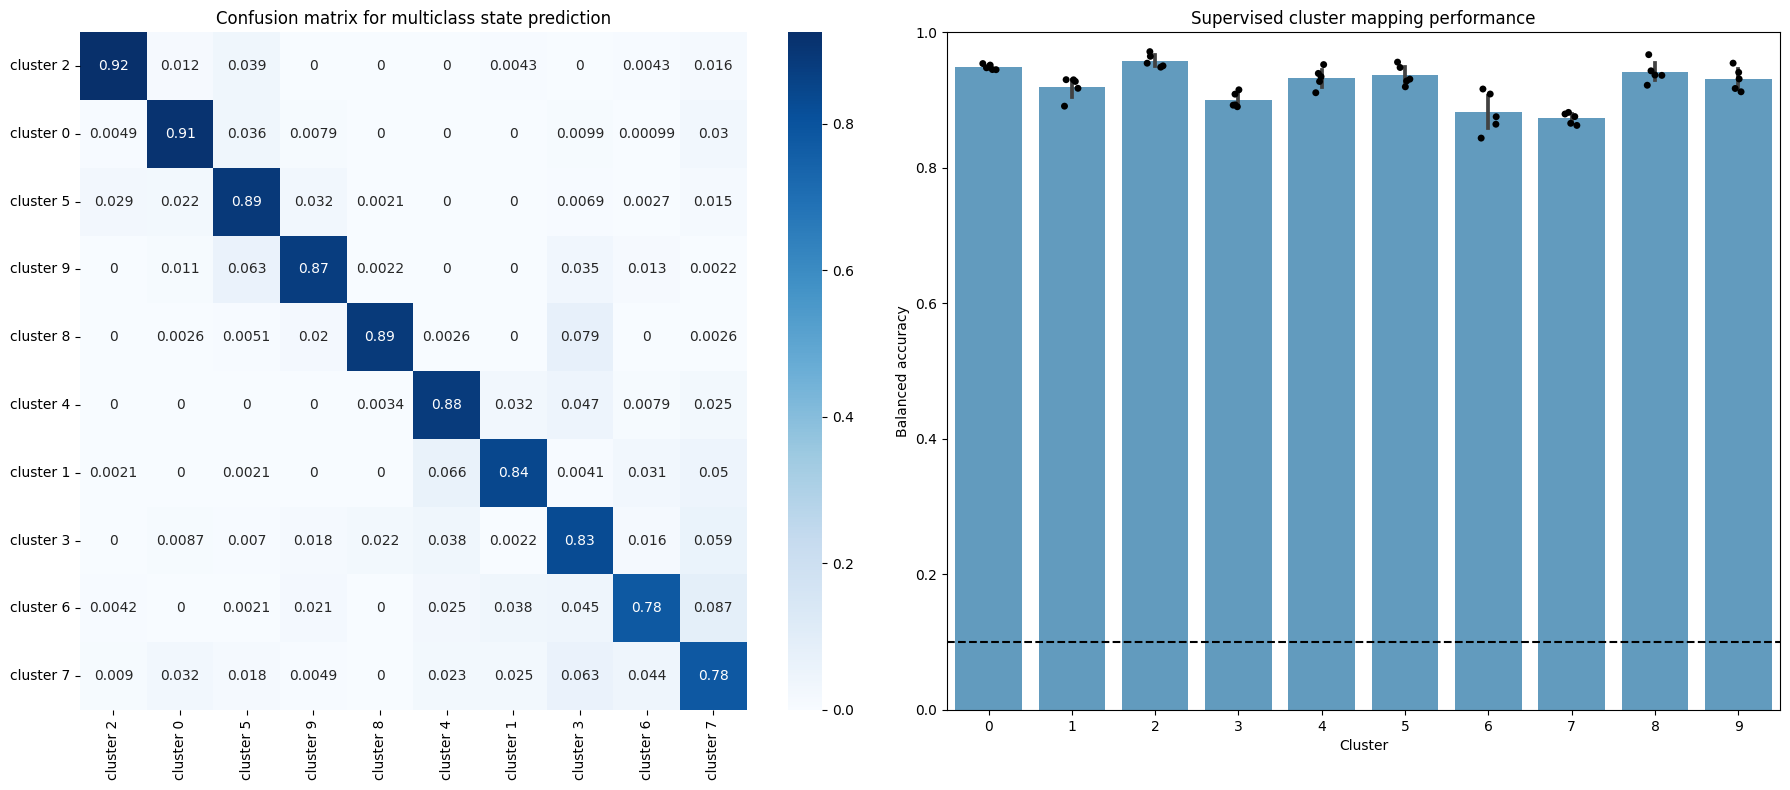

In [27]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 8))

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="confusion_matrix",
    ax=ax,
)

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="balanced_accuracy",
    save=False,
    ax=ax2,
)

plt.tight_layout()
plt.show()

The confusion matrix on the left shows how the proportion of allocations the model we just trained made in the validation set (all folds are aggregated). The diagonal corresponds then to correct assignments, whereas common errors are shown as off-diagonal high values. This way we can see there are some miss assignments that are more common than others: although the diagonal elements are the highest for all rows, cluster 6 is often confused with cluster 3 and 7, for example. This can be interpreted as a measure of similarity behind the underlying behaviors.

The figure on the right shows the balanced accuracy (which controls for imbalanced data) on the validation set for each fold of the cross-validation loop. Wee see that all clusters perform much higher than random!

With all this out of the way, we're ready to delve into cluster interpretation. To this end, DeepOF relies in [Shapley additive explanations (SHAP)](https://shap.readthedocs.io/en/latest/index.html) a widely adopted toolkit for permutation-based computation of global and local feature importance. Let's run it and explore the results:

**NOTE**: running the cell below can take a considerable amount of time in a large dataset. For didactic purposes, we'll load the precomputed results here.

In [28]:
shap_values, explainer, data_to_explain = deepof.post_hoc.explain_clusters(
    csds_chunk_stats, hard_counts, full_cluster_clf, samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
with open("tutorial_files/tutorial_project/Shap_analysis_results/SHAP_analysis_results_SI_sa.pkl", "rb") as handle:
    shap_values, explainer, data_to_explain = pickle.load(handle)[:3]

The function returns the SHAP values (a detailed explanation of which is beyond the scope of this tutorial, although we will explain how to interpret them), the explainer object, and a formatted version of the same data frame with features we saw before.
Next, let's visualize and interpret the results, using `deepof.visuals.plot_shap_swarm_per_cluster()`:

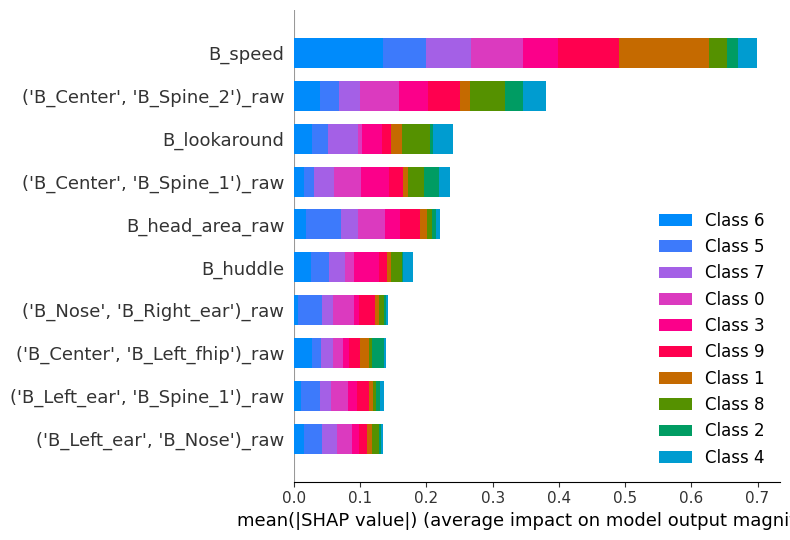

In [30]:
deepof.visuals.plot_shap_swarm_per_cluster(
    my_deepof_project, 
    data_to_explain, 
    shap_values, 
    "all", 
    show=True,
)

The _x_ axis in the figure above depicts the average absolute SHAP values, a measure of feature importance. The _y_ axis shows the names of the top 8 features the model uses to detect across all clusters. Here, we're looking at **global** feature importance for the model; even though this plot is not very informative regarding individual clusters, we can indeed interpret that the most important features overall are speed, spine stretch (distance between the center of the animal and spine 2 — see the scheme in the landing page of the documentation for details), and the lookaround classifier.

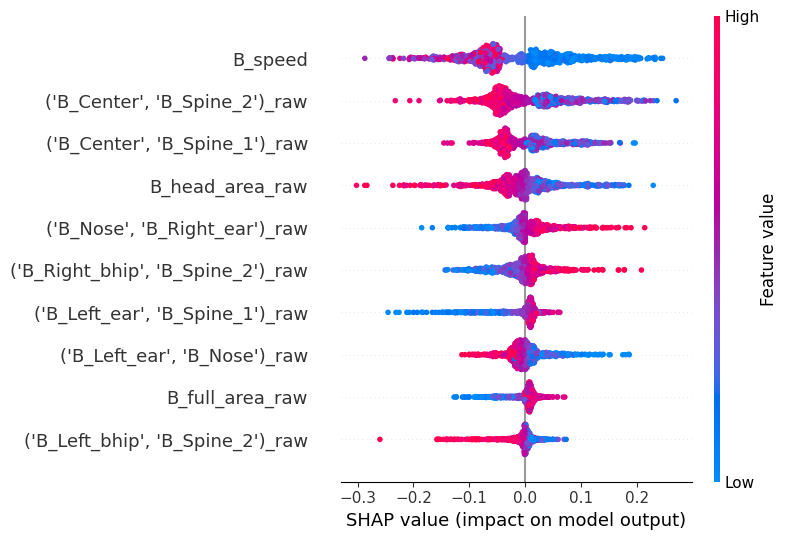

In [31]:
deepof.visuals.plot_shap_swarm_per_cluster(
    my_deepof_project, 
    data_to_explain, 
    shap_values, 
    cluster=0, 
    show=True,
)

Selecting any cluster in the 'cluster' parameter will render a different kind of plot. What we're looking now is called a bee swarm plot, and it's one of the main visualizations the SHAP package has to offer. The y-axis is the same as before (but it's now based on feature importance to detect the cluster that was specifically selected). The _x_ axis, however, shows the raw SHAP values instead of the global absolute value. Positive values indicate an association with the model selecting this specific cluster, whereas negative values indicate an association with the model selecting against this specific cluster. Finally, the color indicates the underlying feature value.

Thus, interpretation lies in detecting associations between the sign of the SHAP values and their color. Red values to the right mean positive associations between a feature and a cluster, whereas blue values on the right mean a negative association. Let's see an example to make it more explicit. 

Go to cluster 0, which we saw it's significantly enriched in stressed animals. We see there seems to be a negative association with speed, and spine stretch! This makes a lot of sense for a stressed animal in this context.

One of the main advantages of working with video data, however, is that we can directly visualize samples representing each cluster. DeepOF offers two main functions to do this, which, in combination with the SHAP pipeline we just covered, can be a pretty powerful tool. Let's see!

### Exporting cluster video snippets

First, we can use the same animation function we saw in the first tutorial, with a few additions. If we pass the embeddings and soft_counts objects into the embedding and cluster_assignments parameters respectively, as well as a specific video to experiment_id, and the index of a selected_cluster, an animated figure with two panels will be created.

The panel on the left shows the embeddings for the whole video, colored by assigned cluster, and marks the current frame with an animated red cursor. The panel on the right shows a representation of the selected frames as an animated video. Note that both animals are shown in the panel on the right, with the experimental subject depicted in blue. We see that the C57Bl6's behavior matches closely what was described above!

In [32]:
video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embeddings=embeddings,
    soft_counts=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    bin_index=0,
    bin_size=6,
    sampling_rate=15,    
    selected_cluster=1,
    dpi=60,
    center="arena",
)

html = display.HTML(video)
display.display(html)
plt.close()

Moreover, `deepof.visuals.export_annotated_video()` can output direct samples taken from the dataset into a real video. The function will concatenate samples from all available experiments, and generate a video with samples from each cluster. The parameter frame_limit_per_video controls how many frames per video should be included (to prevent the output from ending up being too large, especially in big datasets). Let's indeed run it, and load some samples from cluster 1 and into the notebook! The legend below shows the experiment from which each sample was taken.

In [33]:
deepof.visuals.export_annotated_video(
    my_deepof_project,
    soft_counts,
    frame_limit_per_video=100,
)

Exporting behavior videos     : 100%|██████████| 10/10 [01:22<00:00,  8.29s/video]


<img src="./Assets/deepof_unsupervised_annotation_cluster_1_sample_AdobeExpress.gif" width="350">

### Wrapping up

Thank you for making it until the end. In this three-part tutorial series, we covered how to load data into DeepOF, and how to run and interpret results in both supervised and unsupervised pipelines. The fourth (optional) tutorial deals with using custom labelling schemes, and can be found [here](https://deepof.readthedocs.io/en/latest/tutorial_notebooks/deepof_custom_labels_tutorial.html). If you are dealing with particularly large datasets (with recordings being several hours long), tutorial five might be of interest for you, which you can find [here](https://deepof.readthedocs.io/en/latest/tutorial_notebooks/deepof_big_data_tutorial.html). Stay tuned for more content, and make sure to raise an [issue](https://github.com/mlfpm/deepof/issues) in our GitHub repository if you have any questions!